# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [319]:
%matplotlib inline
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
plt.style.use('fivethirtyeight')


# Setup Seaborn
#sns.set_style("whitegrid")
sns.set_context("talk")


pd.set_option('display.max_rows', 200)

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [320]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [321]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the customer name with columns showing the offers they accepted or not  (Use the pandas [merge](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [pivot_table](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [322]:
# Check if there are null values
null_check = pd.concat([df_offers.isnull().sum() , df_transactions.isnull().sum()])
null_check

offer_id         0
campaign         0
varietal         0
min_qty          0
discount         0
origin           0
past_peak        0
customer_name    0
offer_id         0
n                0
dtype: int64

In [323]:
# rows for customer name and columns for offer ids
merged = pd.merge(df_transactions, df_offers, on='offer_id')

In [324]:
# Make a dictionary of customers where values are the offer_id 
customers = df_transactions['customer_name'].unique()
offers = df_offers['offer_id'].unique()

#transects = np.zeros(shape=(len(customers), len(offers)))
transects = {}
for c in customers:
    transects[c] = merged.loc[merged['customer_name']== c, 'offer_id'].values.tolist()    

In [339]:
# Create a dataframe of the size [Customer , OfferId ]
left_bound = len(customers) 
right_bound = len(offers)+1
df_raw = pd.DataFrame(np.zeros(shape=(left_bound, right_bound)), index=transects.keys())

# Fill the dataframe based on transactions of the customer
for key in transects.keys():
    for i in range(len(transects[key])):
        if transects[key][i] in offers:
            df_raw.loc[key, transects[key][i]] = 1

df_raw = df_raw.sort_index()
df_raw.drop(columns=[0], axis=1, inplace=True)
df_raw.head(10)

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Barnes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Bell,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bennett,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Brooks,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brown,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [340]:
# Get Customers accepted offer_id = 32 
for key in transects.keys():    
    if 32 in transects[key]:
        print(key)
        


Cooper
Gomez
Young
Kelly


> So at the last two lines I checked if there is a problem with the `offer_id=32` as I see `NaN` values only here. Apparently it is working fine. The reason we get `NaN` is because of the way `range` function work. It excludes the right point from the range thus `np.zeros` do not see that column and do not fill in with zeros. To prevent is we set up dataframe again passing `number_of_columns = len(offers) + 1`. There are no `NaN`s anymore.

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

> - We do want to `minimize` the SS value as the goal is to get points close to the centroid in a cluster. We are in search of local minimum in this case.  In this step, each data point is assigned to its nearest centroid, based on the squared Euclidean distance (or some other metrics).
>
> - Let's look at the use case of KMeans clustering algorithm: Please Note that if your data has high variance or even outliers then it should be scaled/normalized to get better results but here we do not need to do that as values are around 0.

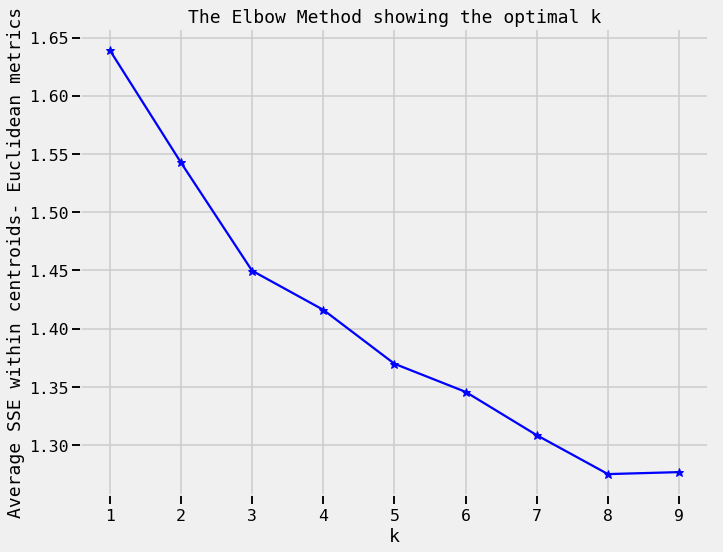

In [342]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

X = df_raw.values

# within cluster SSE
distortions = []

K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k, tol=0.0001).fit(X) 
    kmeans.fit(X)
    # Normalize SSE 
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0])

# Plot the elbow
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(K, distortions, 'b*-')
ax.set_xlabel('k')
# the sum of the squared distances between each observation vector and its dominating centroid
ax.set_ylabel('Average SSE within centroids- Euclidean metrics') 
ax.set_title('The Elbow Method showing the optimal k');
plt.savefig('Elbow')

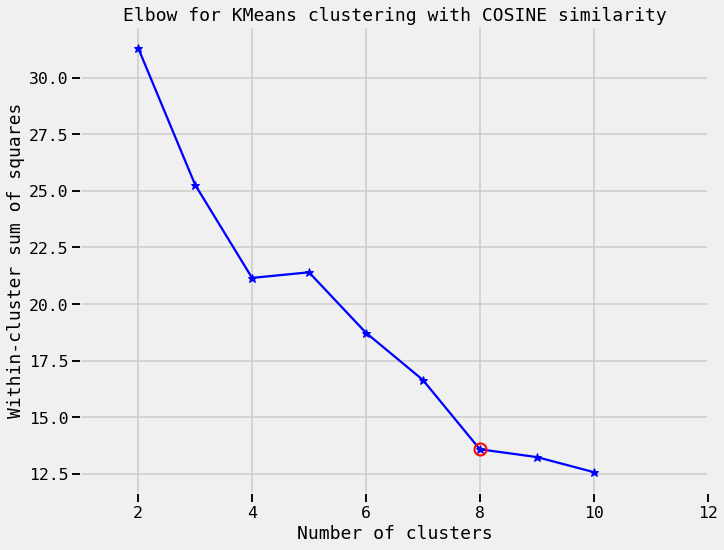

In [343]:
# Determine k
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
import numpy as np

# get Kmean and centroids
K = range(2, 11)
KM = [KMeans(n_clusters=k, init='k-means++').fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

# compute euclidean distance
D_k = [cdist(X, mid, 'cosine') for mid in centroids] # Compute distance between each pair of the two collections of inputs.
dist = [np.min(D,axis=1) for D in D_k]
cIdx = [np.argmin(D,axis=1) for D in D_k]


# Total with-in sum of square
# The within-cluster sum of squares is a measure of the variability of the observations within each cluster
tss = [sum(d**2) for d in dist] 
# Construct a plot showing  SSSS  for each  KK 
fig, ax  = plt.subplots(figsize=(10,8))
ax.set_xlim([1, 12])
ax.plot(K, tss, 'b*-')
ax.plot(K[6], tss[6], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
ax.grid(True)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Within-cluster sum of squares')
ax.set_title('Elbow for KMeans clustering with COSINE similarity')
plt.savefig('ElbowCosine')

**Make a bar chart showing the number of points in each cluster for k-means under the best K**

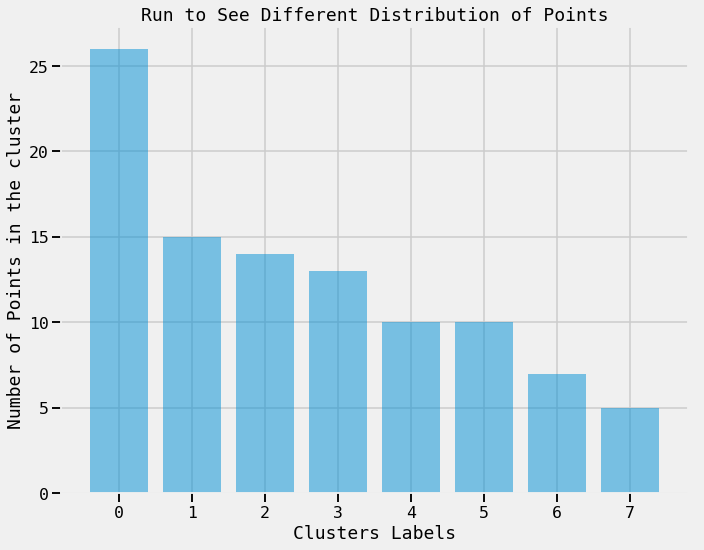

In [346]:
# Set k of your choice and Compute k-means clustering
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(X)

# Make a new dataframe to store results
df_cluster_one = df_raw.copy(deep=True)

# Compute cluster centers and predict cluster index for each sample
df_cluster_one['cluster_labels'] = kmeans.labels_

# How many samples for each centroid
count_samples = df_cluster_one['cluster_labels'].value_counts()
cluster_center = count_samples.index.values

# bar chart
xlim = np.arange(len(cluster_center))
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(xlim, count_samples, align='center', alpha=.50)
ax.set_xticks(cluster_center)
ax.set_xlabel('Clusters Labels')
ax.set_ylabel('Number of Points in the cluster')
ax.set_title('Run to See Different Distribution of Points');

**What challenges did you experience using the Elbow method to pick K**

> Elbow method is not the perfect tool to determine exact number of centroids while in general, there is no method for determining exact value of K. Here, we observed mean distance to the centroid from each data point as K is increasing. We looked at the point where the rate of decrease of mean distance sharply shifts, to roughly determine K.

> For validation of K: There are other techniques exist for validating K, including cross-validation, information criteria, the information theoretic jump method, the silhouette method, and the G-means algorithm. In addition, monitoring the distribution of data points across groups provides insight into how the algorithm is splitting the data for each K. 

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.



| **Range**   | **Interpretation**                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |


Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

> Silouette coefficient score measures how well defined the clusters are. A well-defined cluster will have a small mean distance within each cluster and a large mean distance with the next nearest cluster.

For n_clusters = 2 The average silhouette_score is : 0.18083998472577345
For n_clusters = 3 The average silhouette_score is : 0.2472865728921763
For n_clusters = 4 The average silhouette_score is : 0.19525627680755228
For n_clusters = 5 The average silhouette_score is : 0.22351028815124047
For n_clusters = 6 The average silhouette_score is : 0.2378377945063988
For n_clusters = 7 The average silhouette_score is : 0.2229582184746463
For n_clusters = 8 The average silhouette_score is : 0.16519625001422
For n_clusters = 9 The average silhouette_score is : 0.13850281183466764
For n_clusters = 10 The average silhouette_score is : 0.21195814893178827


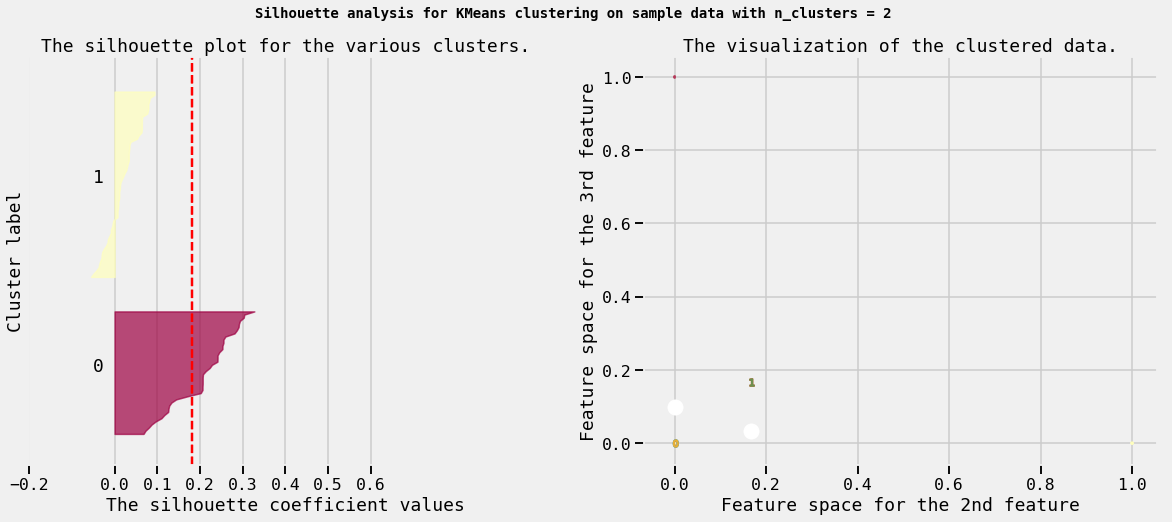

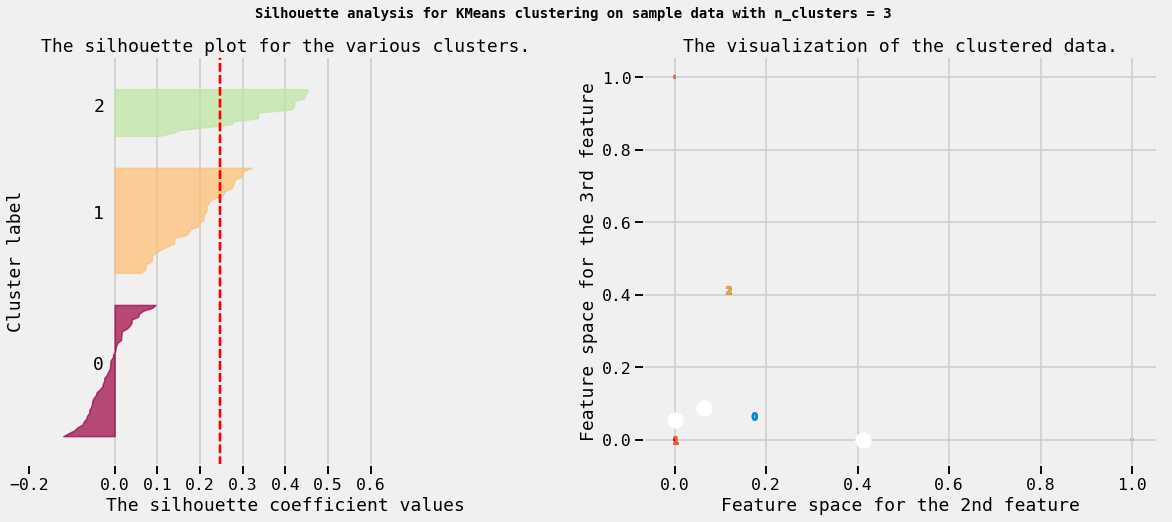

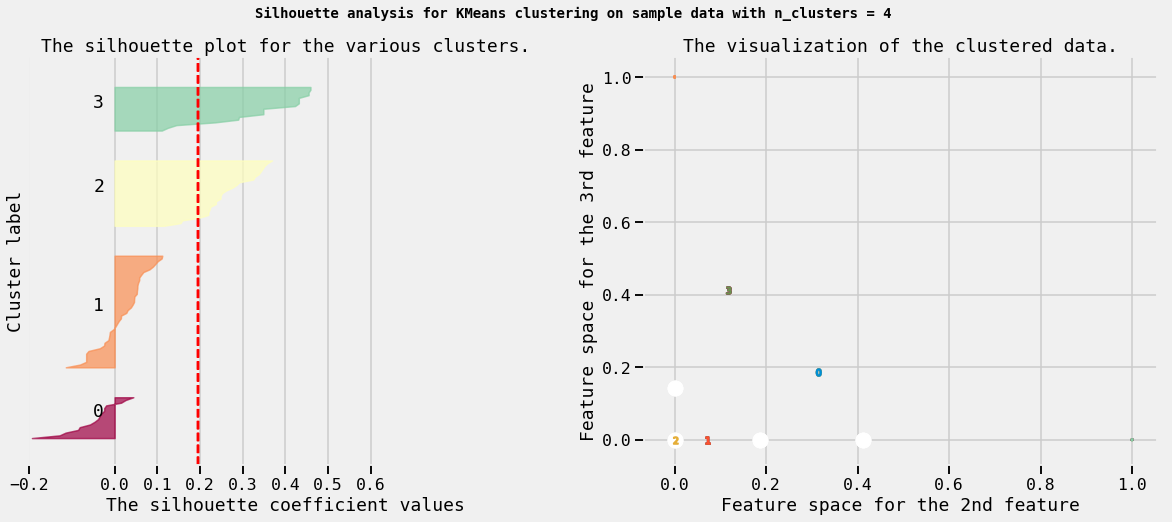

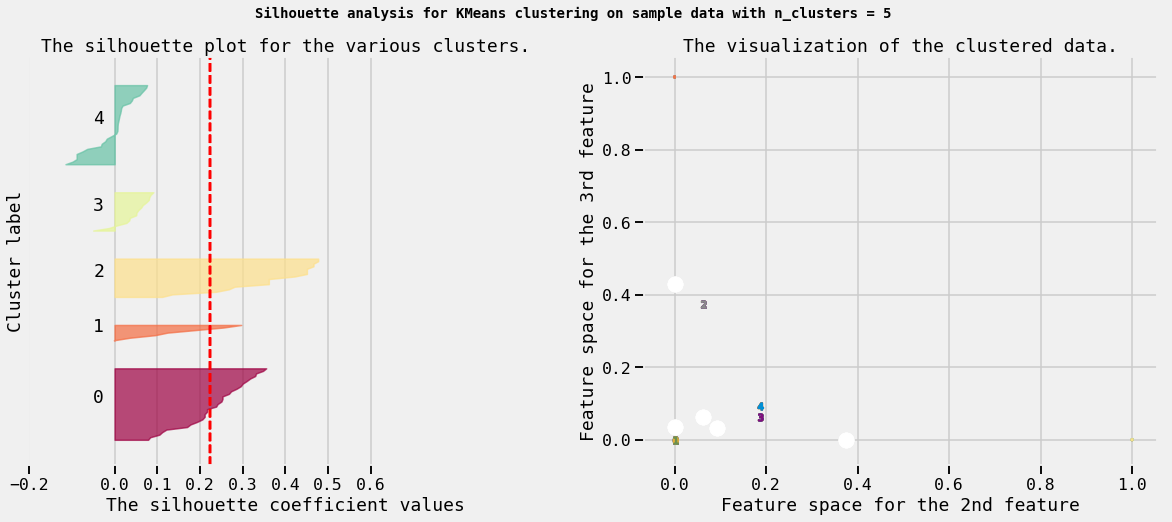

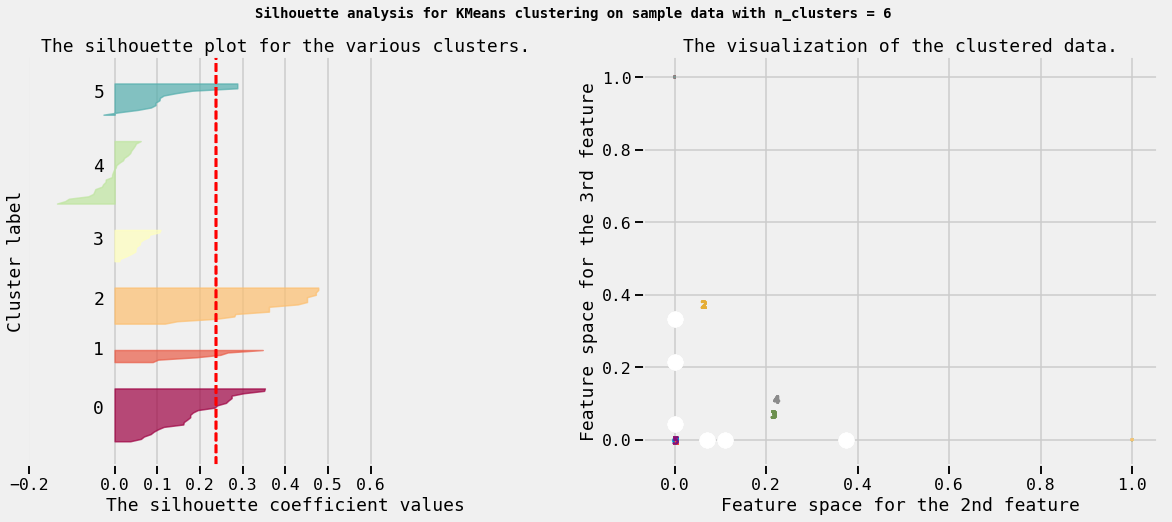

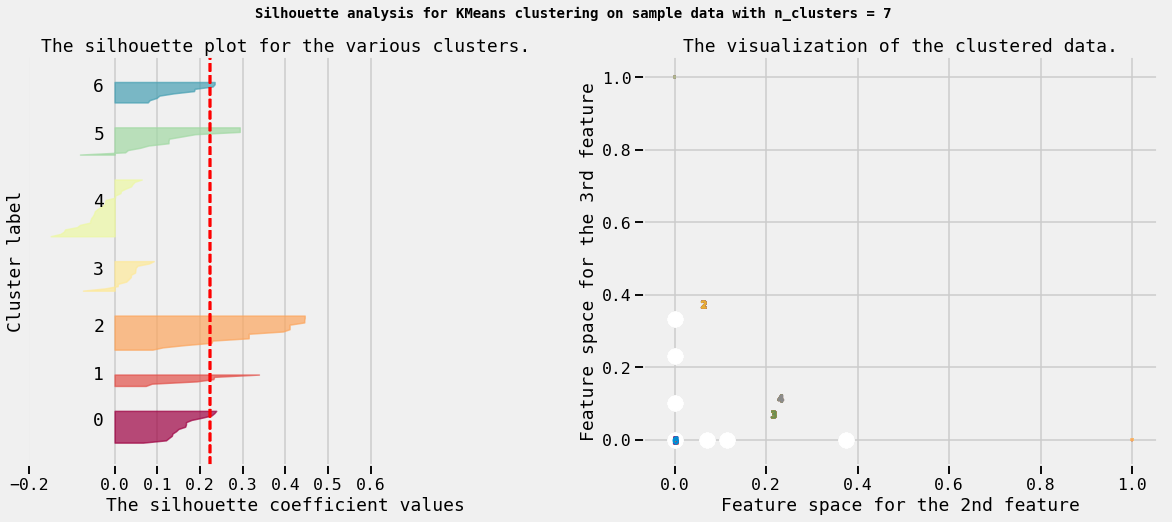

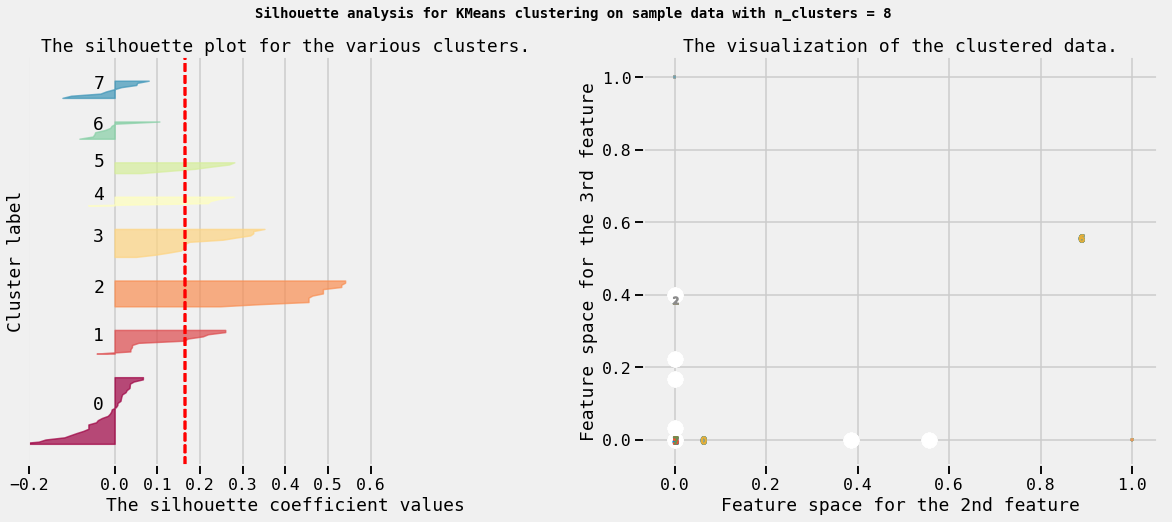

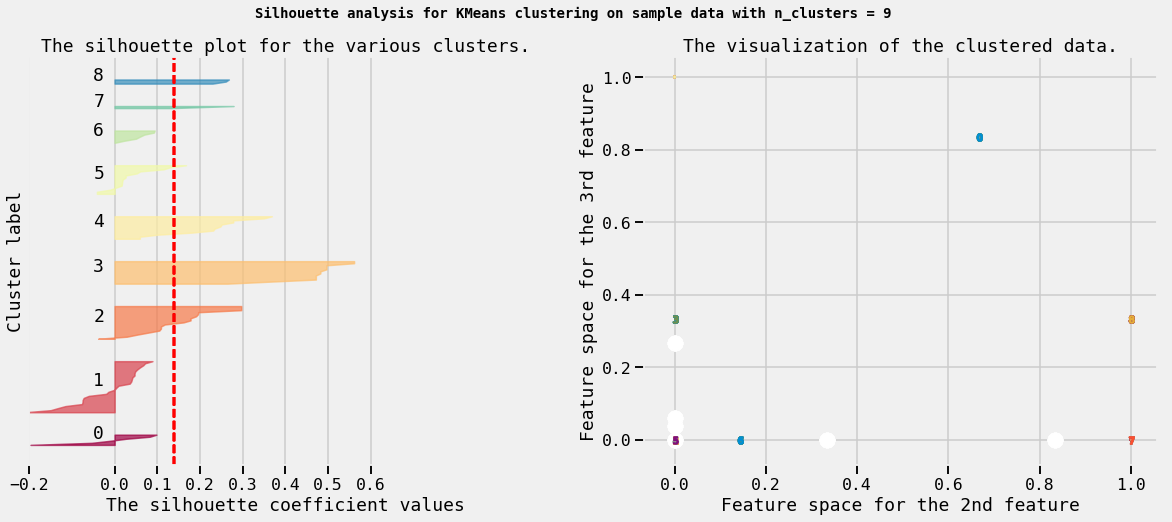

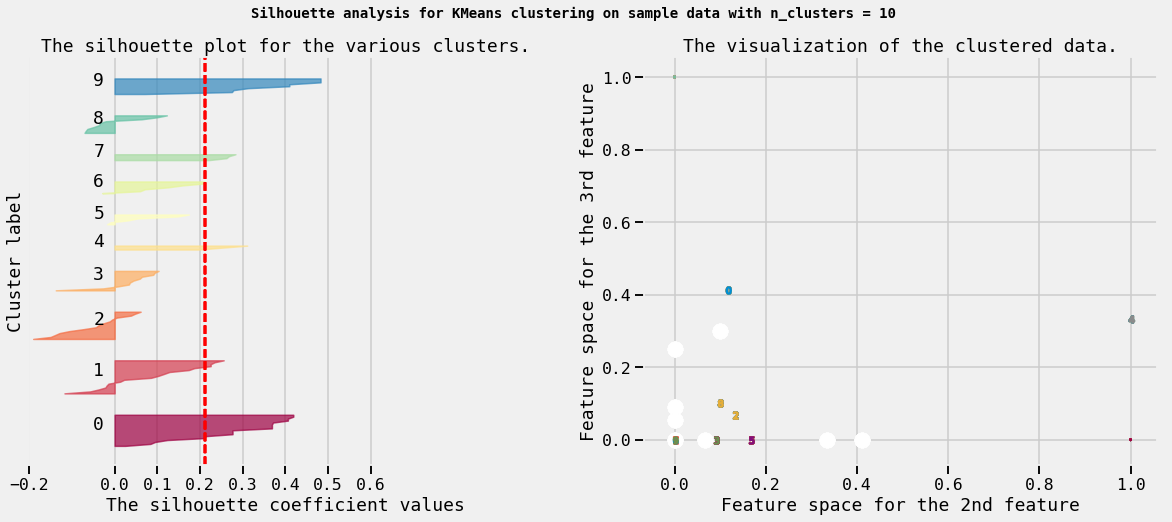

In [347]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

# Line 8 will be used in the next exercise of 1.3.4
store_scores = []

for k in range(2,11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    k_means = KMeans(n_clusters=k, random_state=10)
    cluster_labels = k_means.fit_predict(X)
    
    
    # The silhouette_score gives the average value for ALL the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    sil_score = silhouette_score(X, cluster_labels, metric='cosine') # This function returns the mean Silhouette Coefficient over all samples
    print("For n_clusters =", k,
          "The average silhouette_score is :", sil_score)
    
    # Compute the silhouette scores for EACH sample
    sample_sil_values = silhouette_samples(X, cluster_labels)
    
    # For the next question store silhoutte scores and corresponding number of clusters
    store_scores.append([k, sil_score])
    
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    y_lower = 10
    for i in range(k):
        cluster_i = sample_sil_values[cluster_labels == i]
        cluster_i.sort()
        size_cluster_i = len(cluster_i)
        
        y_upper = y_lower + size_cluster_i
        
        # Pretty graphix
        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_i,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=sil_score, color="red", linestyle="--")
    
        
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.2, 0, 0.1, 0.2, 0.3,  0.4, 0.5, 0.6])
        
        # 2nd Plot showing the actual clusters formed
        cmap = cm.get_cmap("Spectral")
        colors = cmap(cluster_labels.astype(float) / k)
        #colors = cm.Spectral(cluster_labels.astype(float) / k)
        ax2.scatter(X[:, 1], X[:, 2], marker='.', s=30, lw=0, alpha=0.7, c=colors)
        
        # Labeling the clusters
        centers = k_means.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 1], centers[:, 2], marker='o', c="white", alpha=1, s=200)
        
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
        
        
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 2nd feature")
        ax2.set_ylabel("Feature space for the 3rd feature")
        
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data " "with n_clusters = %d" % k), fontsize=14, fontweight='bold');
        
plt.savefig('SilhoutteAnalysis')



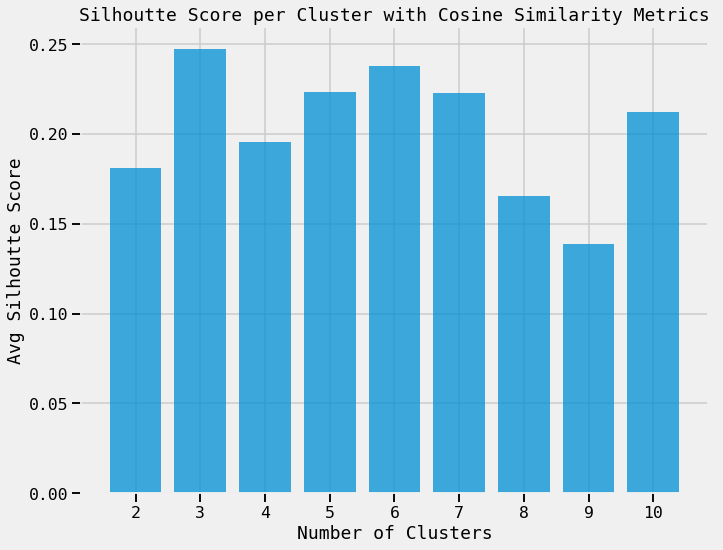

In [349]:
# Call store_scores and make a dataframe out of it
df_avg_sil = pd.DataFrame(store_scores, columns= ['Clusters','Avg_Silhoutte'])

# Prepare for Bar Chart
x_lim = df_avg_sil.Clusters.values
y = df_avg_sil['Avg_Silhoutte']

fig, ax = plt.subplots(figsize=(10,8))
ax.bar(x_lim, y, align='center', alpha=0.75)
ax.set_xticks(x_lim)
ax.set_ylabel( 'Avg Silhoutte Score')
ax.set_xlabel('Number of Clusters')
ax.set_title('Silhoutte Score per Cluster with Cosine Similarity Metrics')
plt.savefig('Silhoutte Score Per Cluster')

> The average silhoutte score for each trial, within our number of clusters range, falls below $.25$ which indicates no substantial structure exist in our dataset. With that in mind, here we used `cosine` similarity function to measure distance. Apparently `k=3` looks better what that is not a practical solution for customer segmentation problem as there are about 30 different offer types. Thus, `k= 6` or `k=7` seems to work. Recall that we have chosen `k=8` when we run Elbow Method. 
> 
> To get better clustering results we better reduce the dimensionality of our data using demension reduction algorithms such as `PCA` method.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

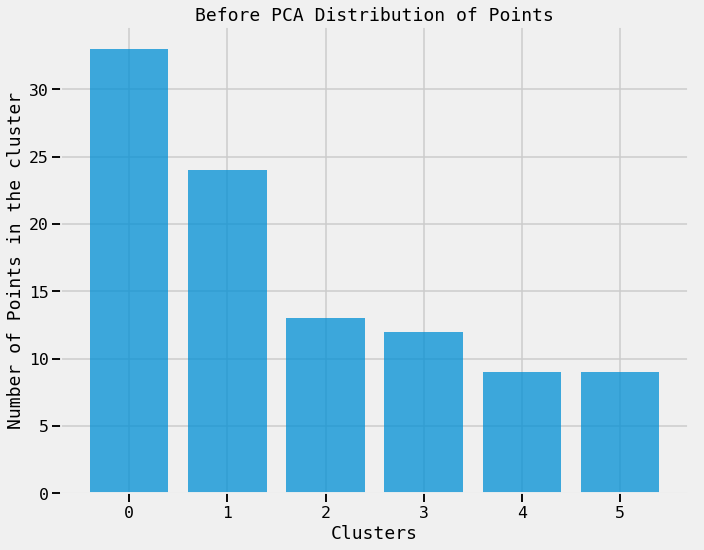

In [355]:
# Before PCA 
# Set k of your choice and Compute k-means clustering
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(X)

# Make another df 
df_cluster_two = df_cluster_one.copy(deep=True)

# Compute cluster centers and predict cluster index for each sample
df_cluster_two['cluster_k_%d'%optimal_k] = kmeans.predict(X)

# How many samples for each centroid
count_samples = df_cluster_two['cluster_k_6'].value_counts()
cluster_labs = count_samples.index.values

# bar chart
xlim = np.arange(len(cluster_labs))
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(xlim, count_samples, align='center', alpha=.75)
ax.set_xticks(cluster_labs)
ax.set_xlabel('Clusters')
ax.set_ylabel('Number of Points in the cluster')
ax.set_title('Before PCA Distribution of Points');

In [400]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Index Customer Name, columns offers they responded 
df_pca = pd.DataFrame(index=df_raw.index)

# Fit and transform then get first two components
df_pca['x'] = pca.fit_transform(X)[:,0] # first pca component
df_pca['y'] = pca.fit_transform(X)[:,1] # second component

df_pca.head(10)

,x,y
Adams,1.007580,0.108215
Allen,-0.287539,0.044715
Anderson,-0.392032,1.038391
Bailey,0.699477,-0.022542
Baker,0.088183,-0.471695
Barnes,-0.485282,-0.725503
Bell,-0.591941,1.506500
Bennett,0.661732,0.090308
Brooks,-0.118943,-0.577499
Brown,1.079827,-0.007488


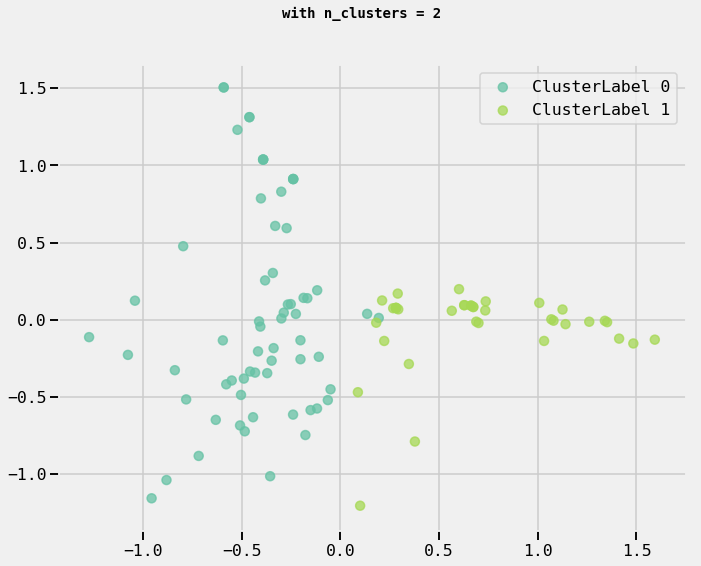

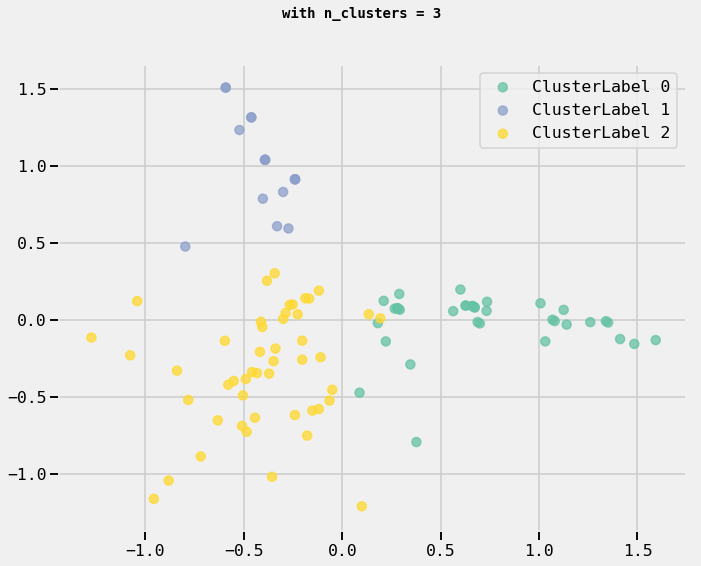

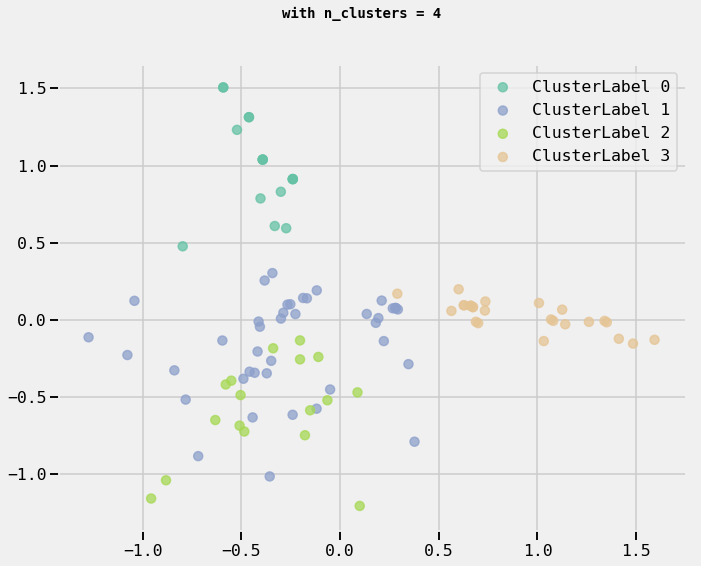

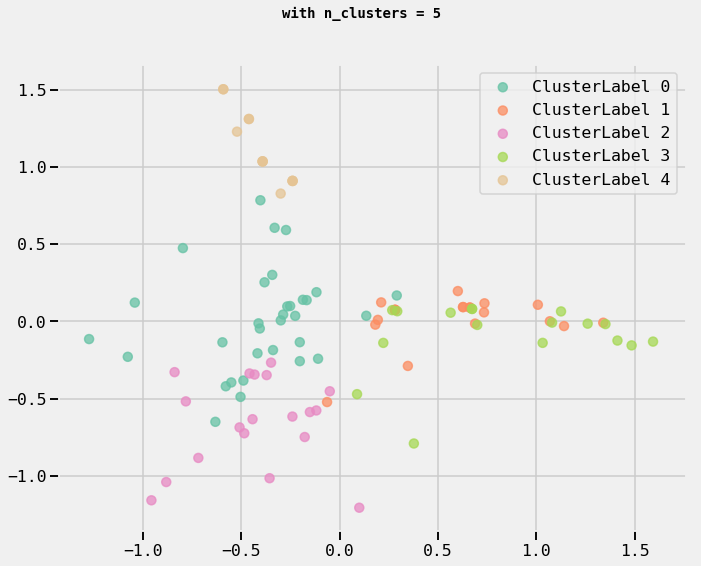

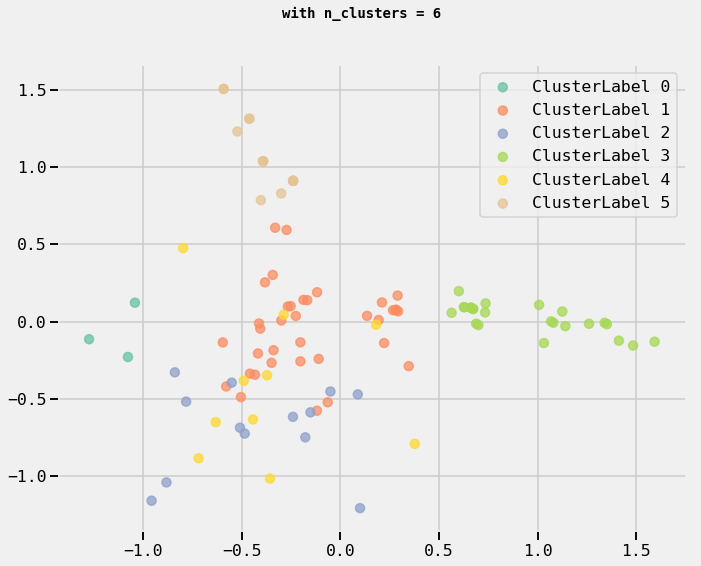

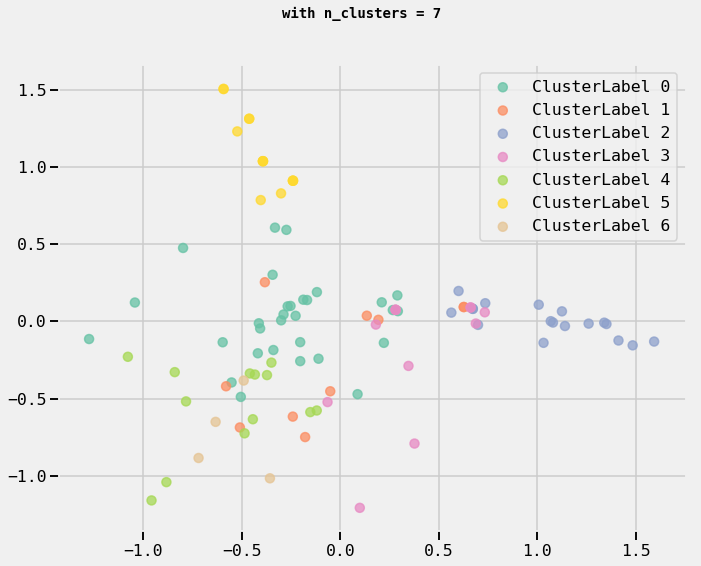

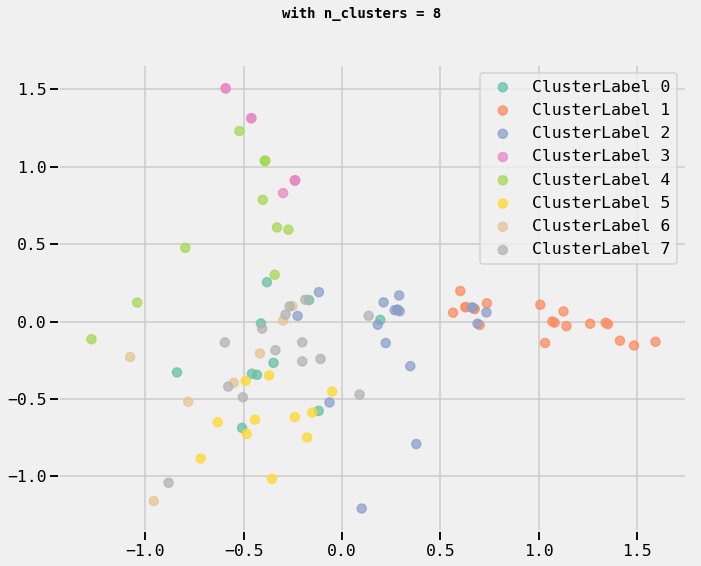

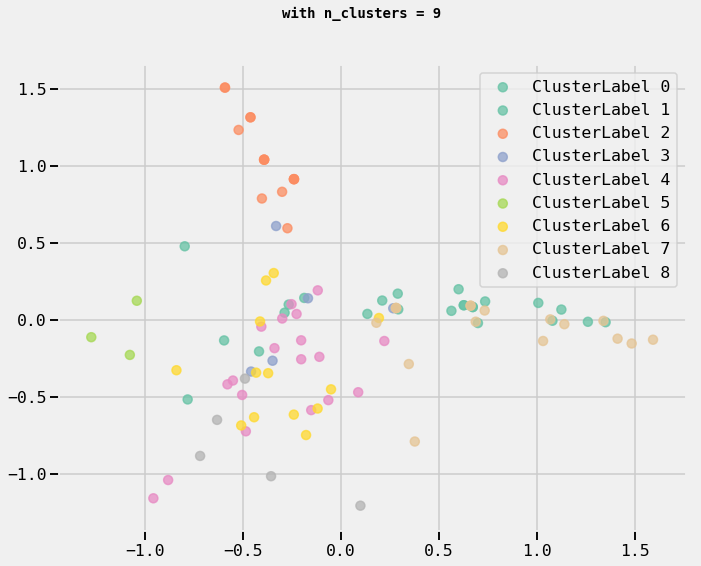

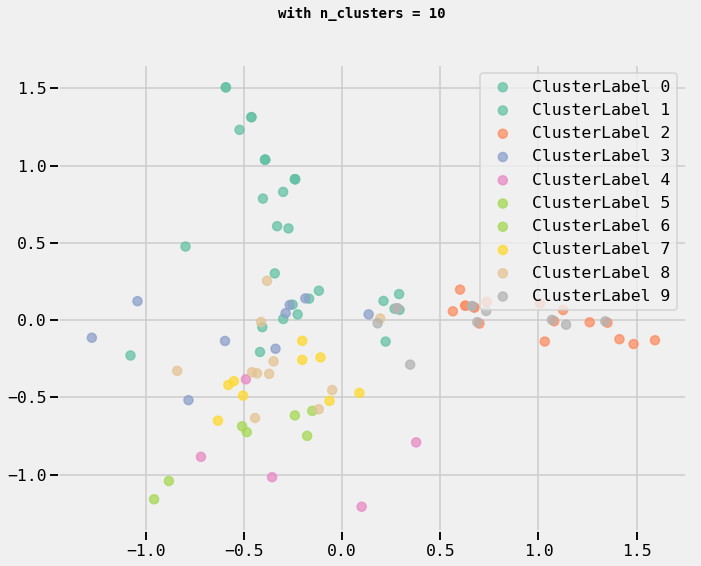

In [466]:
# Find optimal K after PCA is done
for chosen_k in range(2,11):
    model = KMeans(n_clusters = chosen_k)
    labels = model.fit_predict(X)
    df_pca['cluster_id'] = labels
    

    fig,ax = plt.subplots(figsize=(10, 8))
    pn = 0
    for i in range(chosen_k):
        # Create a scatter plot of the 'x' vs 'y'
        cmap = cm.get_cmap('Set2')
        colors = cmap(df_pca['cluster_id'].loc[df_pca['cluster_id']==i].astype('float')/ chosen_k)
        ax.scatter(df_pca['x'].loc[df_pca['cluster_id']==i],
                   df_pca['y'].loc[df_pca['cluster_id']==i],
                   c=colors,
                   alpha=0.75,
                   label='ClusterLabel %d'%i)
        plt.suptitle(("with n_clusters = %d" % (i+1)), fontsize=14, fontweight='bold')
    ax.legend()
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")
    plt.savefig('when_k_%d'%(i+1) + '.png')
    

> After PCA and graphs above, visualizing the data in two-dimensional space reveals that clusters are well separated from each other when k = 3. For k bigger than 3 clusters get overlapsing on each other, so patterns would not be seen clearly if any exists.
>
> Before PCA, the Elbow method seems to give a good idea about what k value should be.


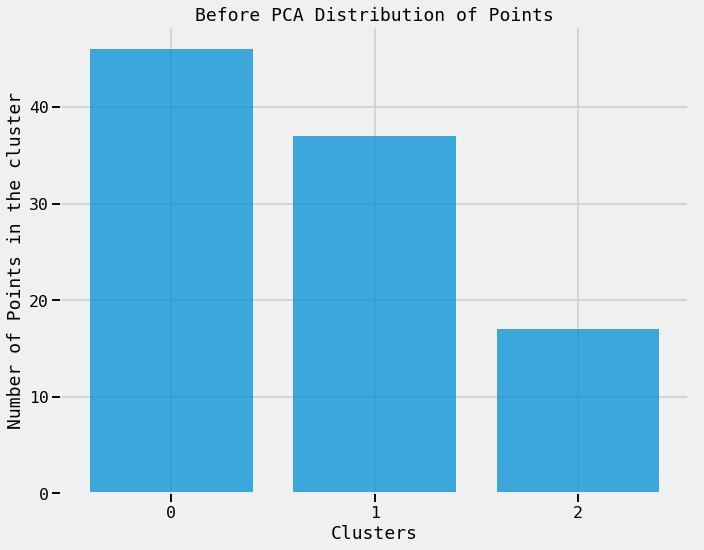

In [476]:
# After PCA 
# Set k of your choice and Compute k-means clustering
optimal_k_pca = 3
kmeans = KMeans(n_clusters=optimal_k_pca)
kmeans.fit(X)

# Compute cluster centers and predict cluster index for each sample
df_pca['cluster_k_%d'%optimal_k_pca] = kmeans.predict(X)

# How many samples for each centroid
count_samples = df_pca['cluster_k_%d'%optimal_k].value_counts()
cluster_labs = count_samples.index.values

# bar chart
xlim = np.arange(len(cluster_labs))
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(xlim, count_samples, align='center', alpha=.75)
ax.set_xticks(cluster_labs)
ax.set_xlabel('Clusters')
ax.set_ylabel('Number of Points in the cluster')
ax.set_title('Before PCA Distribution of Points');

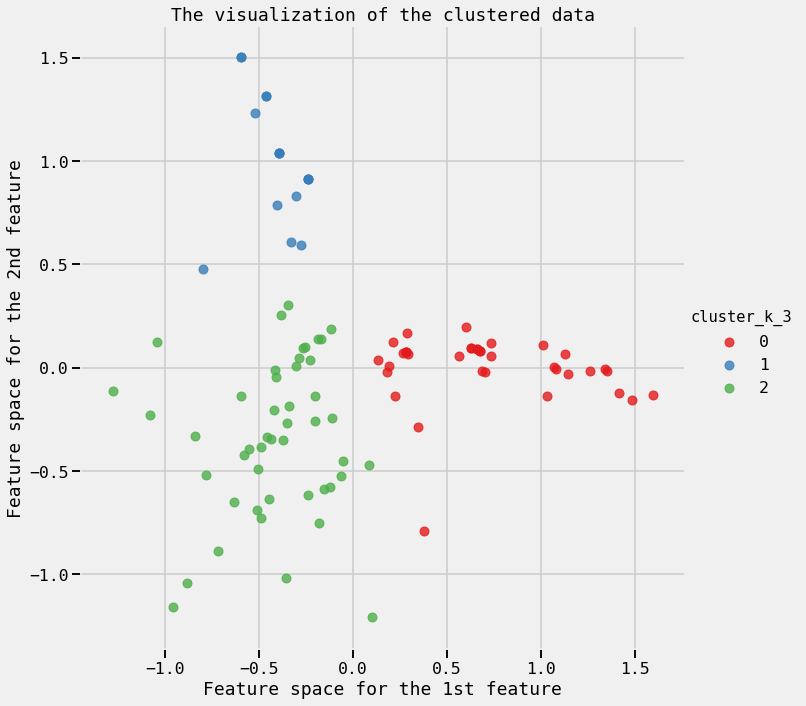

In [547]:
sns.lmplot(data=df_pca, x='x', y='y', hue='cluster_k_3', fit_reg=False, height=10, palette='Set1')
plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature");

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

**Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?**

In [559]:
raw_data = merged.set_index('customer_name').copy(deep=True)
new_merged_df = raw_data.join(df_pca, on=raw_data.index).drop(['n', 'x', 'y'], axis=1)

In [562]:
new_merged_df

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,cluster_k_3
customer_name,,,,,,,,
Smith,2,January,Pinot Noir,72,17,France,False,1
Rodriguez,2,January,Pinot Noir,72,17,France,False,1
Martin,2,January,Pinot Noir,72,17,France,False,2
Jackson,2,January,Pinot Noir,72,17,France,False,2
Campbell,2,January,Pinot Noir,72,17,France,False,1
Mitchell,2,January,Pinot Noir,72,17,France,False,2
Peterson,2,January,Pinot Noir,72,17,France,False,1
Bell,2,January,Pinot Noir,72,17,France,False,1
Cox,2,January,Pinot Noir,72,17,France,False,1


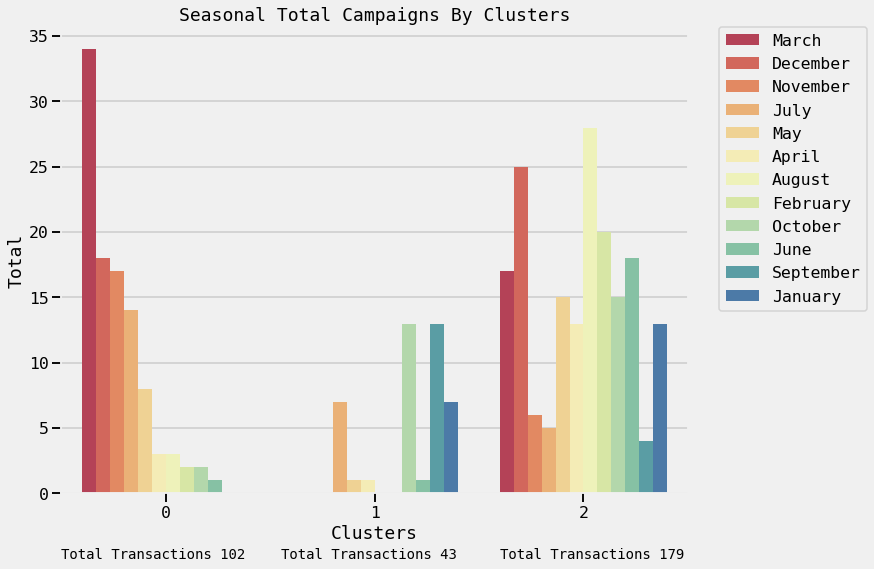

In [769]:
# Total transactions per Clusters
total_trans = pd.crosstab(new_merged_df['cluster_k_3'], columns=['campaign']).values.reshape((3,)).tolist()

# Take a look at seasonal number of campaings
ds = pd.DataFrame()
ds['Total'] = new_merged_df.groupby('cluster_k_3')['campaign'].value_counts()
ds = ds.reset_index()

fig, ax =plt.subplots(figsize=(10,8))
sns.barplot(x='cluster_k_3', y='Total', hue='campaign', data=ds, ax=ax, palette='Spectral')
ax.set_xlabel('Clusters')
ax.set_title('Seasonal Total Campaigns By Clusters')

# Info bar at the bottom for each cluster
space = 0.0
for item in range(len(total_trans)):
    
   
    ax.text(x=-.5+space, y=-5, s= 'Total Transactions %d'%total_trans[item], withdash=True, fontsize=14)
    space +=1.05
# Put the legend out of the figure
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('TotalTransPerCluster')

>For Cluster 0 March is the month the company need to definitely checkout on what type of offers, what type of products are gone in this group.
>
>August and December are important season of the year in Cluster 2 in terms of transactions.
>
> Cluster 1 seems to be weak except October and September (Fall Season)
>
> In general, transaction volume in Cluster 2 seems to be larger than the others.

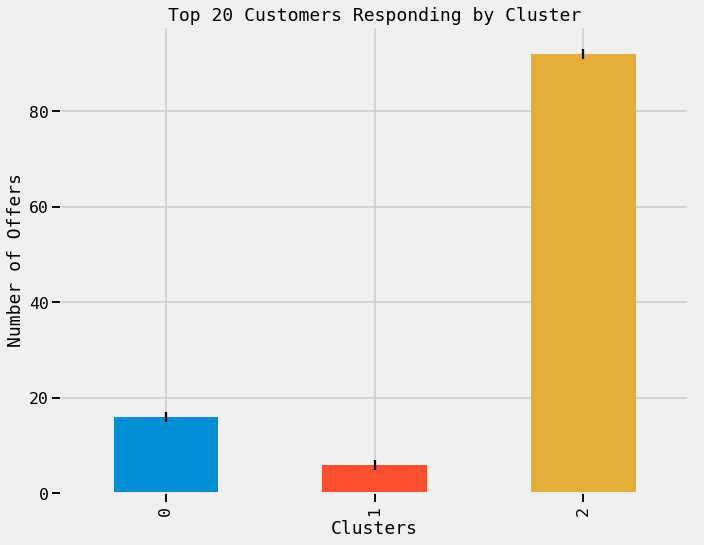

In [681]:
top_20_transactions = new_merged_df.groupby(new_merged_df.index)['offer_id'].size().sort_values(ascending=False)[:20].index.tolist()
top_20_df = new_merged_df.loc[top_20_transactions]
plt.figure(figsize=(10,8))
top_20_df.groupby('cluster_k_3')['campaign'].size().plot(kind='bar',yerr=True)
plt.title('Top 20 Customers Responding by Cluster')
plt.ylabel('Number of Offers')
plt.xlabel('Clusters');

> Transaction volume of top 20 customers (meaning $20\%$ of customer overall) accumulated in Cluster 2. Most of these transactions most likely happens in December and/or August according to seasonal chart above. Let's take a look at what they ordered.

In [691]:
top_20_df.groupby('campaign')['varietal'].mean()

DataError: No numeric types to aggregate

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [770]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)



PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

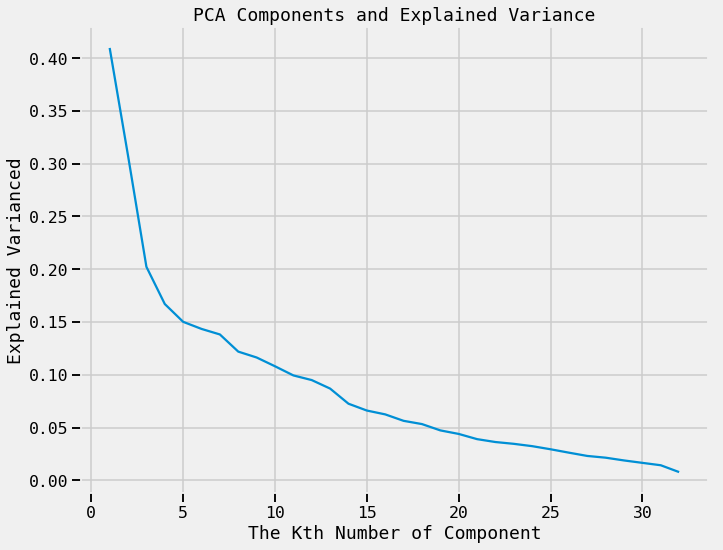

In [772]:
# Plot the explained variance by each component
plt.figure(figsize=(10,8))
plt.plot(range(1,33), pca.explained_variance_)
plt.xlabel('The Kth Number of Component')
plt.ylabel('Explained Varianced')
plt.title('PCA Components and Explained Variance')
plt.show()

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


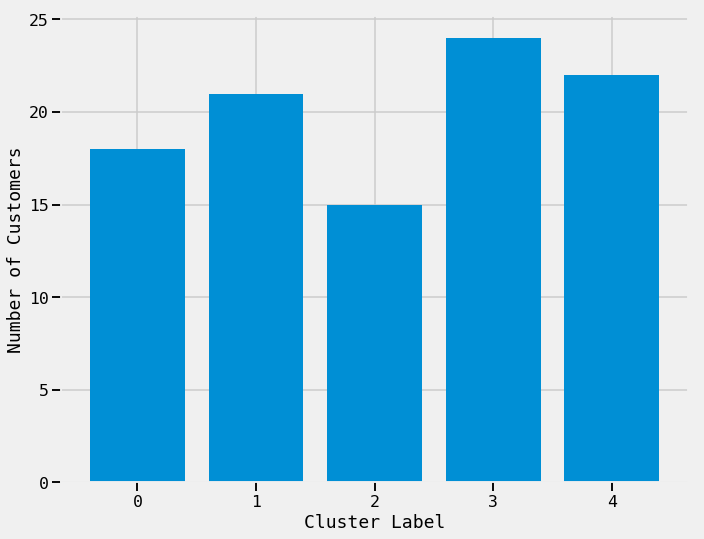

In [775]:
# Affinity propagation
from sklearn.cluster import AffinityPropagation
aff = AffinityPropagation(preference=-15)
aff_labels = aff.fit_predict(X)

# Plot
plt.figure(figsize=(10,8))
plt.hist(aff_labels, bins=5,  align='left', range=(0,5), rwidth=0.8)
plt.xticks(range(0,5))
plt.xlabel('Cluster Label')
plt.ylabel('Number of Customers')
plt.show()

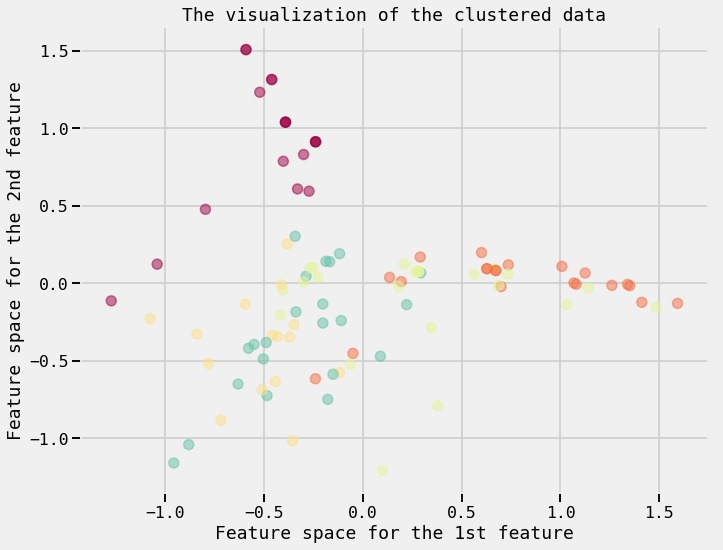

In [778]:
# Create a scatter plot of the two principal components 
cmap = cm.get_cmap('Spectral')
colors = cmap(aff_labels.astype(float) / 5)
plt.figure(figsize=(10,8))
plt.scatter(df_pca.x, df_pca.y, marker='o', s=100, alpha=0.5, c=colors)
plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

Spectral Clustering requires the number of clusters to be specified and works well for small number of clusters. With four clusters, the visualized Spectral Clustering plot shows three distinct clusters and one smaller cluster overlapping with two other clusters

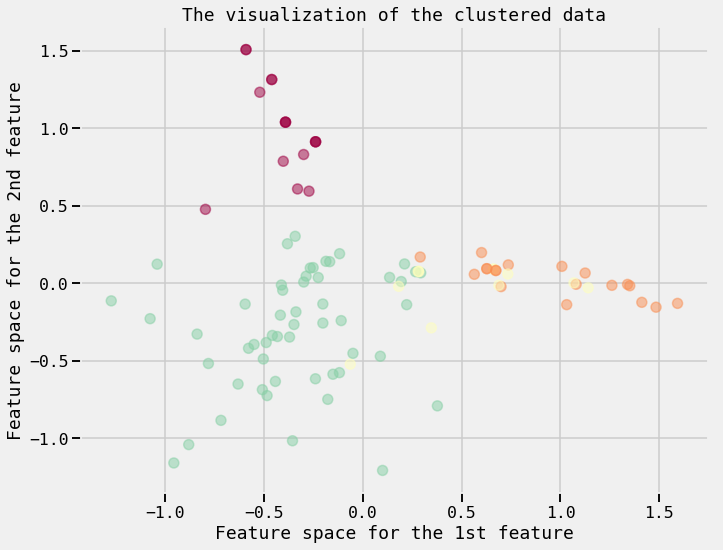

In [781]:
from sklearn.cluster import SpectralClustering
spec = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0)
spec_labels = spec.fit_predict(X)

# Create a scatter plot of the two principal components 
cmap = cm.get_cmap('Spectral')
colors = cmap(spec_labels.astype(float) / 4)
plt.figure(figsize=(10,8))
plt.scatter(df_pca.x, df_pca.y, marker='o', s=100, alpha=0.5, c=colors)
plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

Agglomerative Clustering performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together.

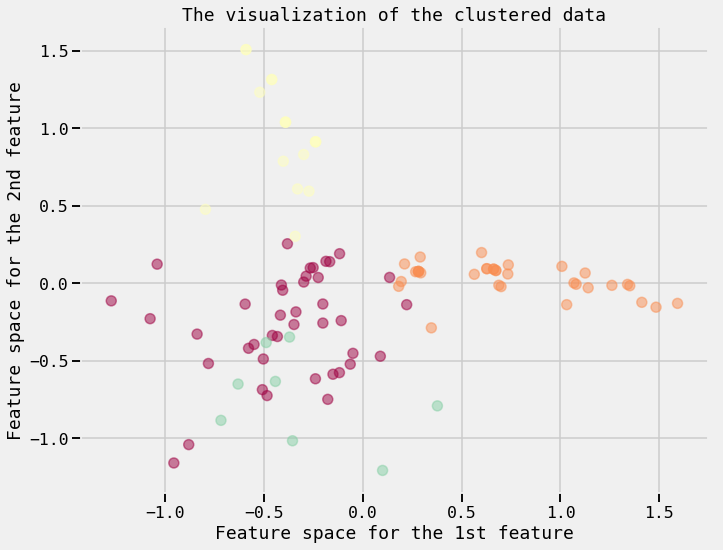

In [782]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_labels = agg.fit_predict(X)

# Create a scatter plot of the two principal components 
cmap = cm.get_cmap('Spectral')
colors = cmap(agg_labels.astype(float) / 4)
plt.figure(figsize=(10,8))
plt.scatter(df_pca.x, df_pca.y, marker='o', s=100, alpha=0.5, c=colors)
plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

In [ ]:
customers['cluster'] = agg_labels
df_clusters = customers.groupby('cluster').mean()
df_clusters = df_clusters.stack().unstack('cluster').reset_index()
df = pd.merge(df_clusters, df_offers, how='left', on='offer_id')
df[df>0.25].fillna('')